# Underfitting / overfitting tradeoff with spline-based Poisson regression

In [1]:
import numpy as np
from scipy import stats
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
stats.lognorm.rvs(1., loc=[0, 1, 2])

array([0.24287009, 1.31481132, 3.15322173])

In [3]:
X = np.random.uniform(0, 4.5 * 2 * np.pi, size=1000).reshape(-1, 1)

def ground_truth_mean(x):
    return np.sin(x) + 1

y = stats.lognorm.rvs(1., loc=ground_truth_mean(X.ravel()), scale=ground_truth_mean(X.ravel()) / 2)


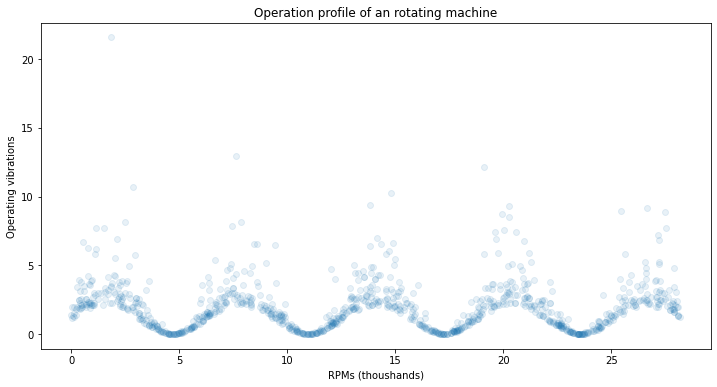

In [38]:
plt.figure(figsize=(12, 6))

plt.scatter(X.ravel(), y, alpha=0.1)

x_grid = np.linspace(X.min(), X.max(), 1000)
# plt.plot(x_grid, ground_truth_mean(x_grid), "--", label="Mean")

plt.ylabel("Operating vibrations")
plt.xlabel("RPMs (thoushands)")
plt.title("Operation profile of an rotating machine");

In [48]:
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import validation_curve
from sklearn.model_selection import ShuffleSplit


spline_reg = make_pipeline(
    SplineTransformer(),
    PoissonRegressor(alpha=1e-4, max_iter=1000),
)

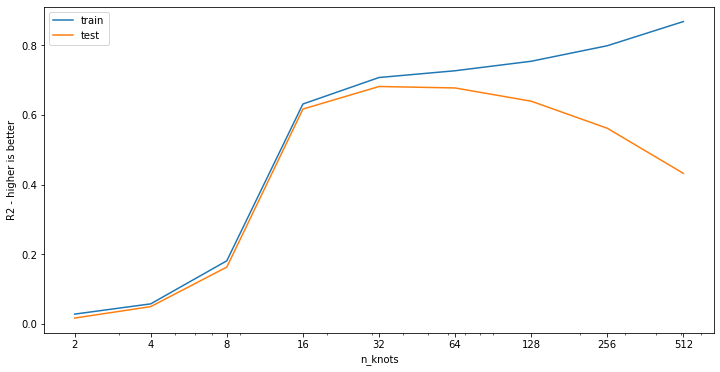

In [51]:
def plot_validation_curve(model, X, y, param_name, param_range):
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    train_scores, test_scores = validation_curve(
        model,
        X,
        y,
        param_name=param_name,
        param_range=param_range,
        cv=cv,
    )
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.semilogx(param_range, train_scores.mean(axis=1), label="train")
    ax.semilogx(param_range, test_scores.mean(axis=1), label="test")
    ax.set_xticks(param_range, param_range)
    short_name = param_name.rsplit("__", 1)[1] if "__" in param_name else param_name
    ax.set_xlabel(short_name)
    ax.set_ylabel("R2 - higher is better")
    ax.legend();
    

param_range = [2, 4, 8, 16, 32, 64, 128, 256, 512]
plot_validation_curve(spline_reg, X, y, param_name="splinetransformer__n_knots", param_range=param_range)

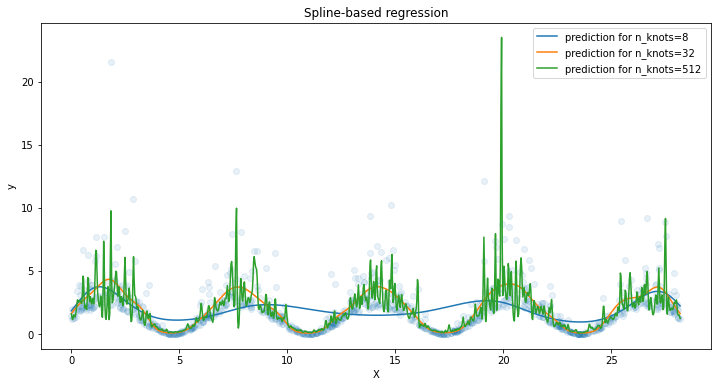

In [53]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(X.ravel(), y, alpha=0.1);

X_test = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
for n_knots in [8, 32, 512]:
    spline_reg.set_params(splinetransformer__n_knots=n_knots)
    spline_reg.fit(X, y)
    ax.plot(X_test.ravel(), spline_reg.predict(X_test), label=f"prediction for n_knots={n_knots}")
ax.set(
    xlabel="X",
    ylabel="y",
    title="Spline-based regression"
)
ax.legend();

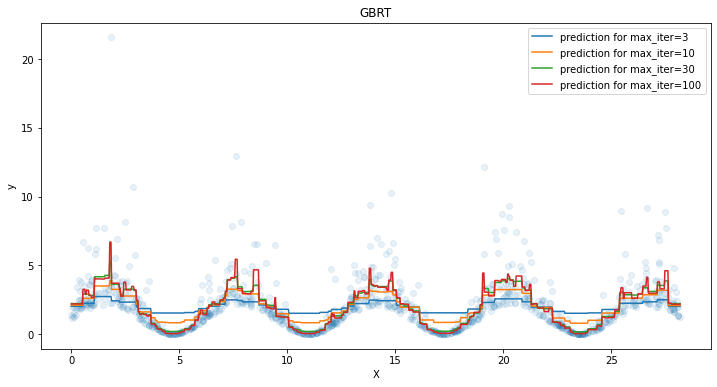

In [54]:
from sklearn.ensemble import HistGradientBoostingRegressor

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(X.ravel(), y, alpha=0.1);


model = HistGradientBoostingRegressor(loss="poisson")

X_test = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
for max_iter in [3, 10, 30, 100]:
    model.set_params(max_iter=max_iter)
    model.fit(X, y)
    ax.plot(X_test.ravel(), model.predict(X_test), label=f"prediction for max_iter={max_iter}")
ax.set(
    xlabel="X",
    ylabel="y",
    title="GBRT"
)
ax.legend();

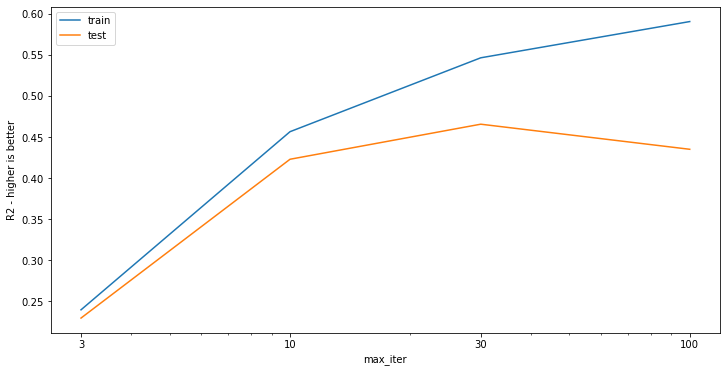

In [55]:
param_range = [3, 10, 30, 100]
plot_validation_curve(model, X, y, param_name="max_iter", param_range=param_range)